# Часть 2: Очистка данных и подготовка к анализу

### Описание данных:

В рамках анализа используем данные о вакансиях, подходящих для студентов, обучающихся на программе "Бизнес-информатика" университета ИТМО, собранные с платформы hh.ru на момент 29.04.2025.

---

Датасет содержит информацию об актуальных предложениях по ключевым словам и тегам, а также включает некоторые требования к кандидатам (опыт работы, тим занятости, график работы, рабочие часы, формат работы) и данные о предлагаемой заработной плате.

In [2]:
# Устанавливаем необходимые библиотеки
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from collections import Counter
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns


# Импорт файла из Google Drive (пример взят из https://saturncloud.io/blog/how-to-load-an-xlsx-file-from-google-drive-in-google-colaboratory/)
drive.mount('/content/drive')
filename = 'vacancies_spb_20250429_113026.xlsx'
search_path = '/content/drive/My Drive'

# Поиск файла
file_path = None
for root, dirs, files in os.walk(search_path):
    if filename in files:
        file_path = os.path.join(root, filename)
        break

# Загрузка данных
df = pd.read_excel(file_path)

# Настройка отображения графиков
plt.style.use('ggplot')
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)


# Предварительный просмотр структуры данных и типов переменных

df.info()
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4175 entries, 0 to 4174
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Название вакансии   4175 non-null   object
 1   Компания            4175 non-null   object
 2   Рейтинг компании    4175 non-null   object
 3   Зарплата            4175 non-null   object
 4   Опыт работы         4175 non-null   object
 5   Тип занятости       4175 non-null   object
 6   График работы       4175 non-null   object
 7   Рабочие часы        4175 non-null   object
 8   Формат работы       4175 non-null   object
 9   Ссылка на вакансию  4175 non-null   object
dtypes: object(10)
memory usage: 326.3+ KB


,Название вакансии,Компания,Рейтинг компании,Зарплата,Опыт работы,Тип занятости,График работы,Рабочие часы,Формат работы,Ссылка на вакансию
0,Frontend-разработчик,Профессиональные Комплексные Решения,Нет рейтинга,150000 - 180000 RUR,От 3 до 6 лет,Полная занятость,Полный день,Не указано,Офис,https://hh.ru/vacancy/119540293
1,UI/UX Designer Middle,MVKANEPE GMBH,Нет рейтинга,100000 - 150000 RUR,От 1 года до 3 лет,Полная занятость,Удаленная работа,Не указано,Не указано,https://hh.ru/vacancy/119032276
2,Бизнес-аналитик,"ЕТС, Группа Компаний",Нет рейтинга,от 150000 RUR,От 1 года до 3 лет,Полная занятость,Полный день,Не указано,Офис,https://hh.ru/vacancy/119507435
3,Стажер в IT-отдел,Медицинские системы и технологии,Нет рейтинга,Не указано,Нет опыта,Частичная занятость,Полный день,Не указано,Офис,https://hh.ru/vacancy/120061749
4,Менеджер проектов CS,Авито,Нет рейтинга,Не указано,От 1 года до 3 лет,Полная занятость,Удаленная работа,Не указано,Не указано,https://hh.ru/vacancy/119483577


### Для удобства работы следует провести следующие операции над данными:


1. Привести названия столбцов к формату snake_case

2. Привести значения зарплат и опыта работы к типу Int64

3. Привести значения типа занятости, графика работы и рабочих часов к типу category

In [3]:
# Очистка и переименование названий столбцов
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('-', '_')

df = df.rename(columns={
    'название_вакансии': 'position',
    'компания': 'company',
    'рейтинг_компании': 'company_rating',
    'зарплата': 'salary',
    'опыт_работы': 'experience',
    'тип_занятости': 'employment_type',
    'график_работы': 'work_schedule',
    'рабочие_часы': 'working_hours',
    'формат_работы': 'work_format',
    'ссылка_на_вакансию': 'url'})


import pandas as pd
import numpy as np

# Курсы валют
USD_RATE = 83
EUR_RATE = 93

# Извлекаем числовые значения и валюту
salary_parts = df['salary'].str.extract(
    r'(?P<min_salary>\d+)\s*-\s*(?P<max_salary>\d+)\s*(?P<currency>USD|EUR|RUR)|'  # Диапазон (1000-2000 USD)
    r'от\s*(?P<min_only>\d+)\s*(?P<currency_min>USD|EUR|RUR)|'  # "от 1000 USD"
    r'до\s*(?P<max_only>\d+)\s*(?P<currency_max>USD|EUR|RUR)'   # "до 2000 EUR"
)

# Объединяем валюту из разных групп regex в один столбец
salary_parts['currency'] = (
    salary_parts['currency']
    .fillna(salary_parts['currency_min'])
    .fillna(salary_parts['currency_max'])
)

# Заполняем min и max зарплаты
df['min_salary'] = pd.to_numeric(
    salary_parts['min_salary'].fillna(salary_parts['min_only']),
    errors='coerce'
)
df['max_salary'] = pd.to_numeric(
    salary_parts['max_salary'].fillna(salary_parts['max_only']),
    errors='coerce'
)

# Добавляем столбец с валютой в df
df['currency'] = salary_parts['currency']

# Конвертируем в рубли по курсу
for col in ['min_salary', 'max_salary']:
    df.loc[df['currency'] == 'USD', col] = df.loc[df['currency'] == 'USD', col] * USD_RATE
    df.loc[df['currency'] == 'EUR', col] = df.loc[df['currency'] == 'EUR', col] * EUR_RATE

# Приводим к целому типу (Int64, чтобы поддерживать NaN)
df[['min_salary', 'max_salary']] = df[['min_salary', 'max_salary']].astype(pd.Int64Dtype())

# Удаляем временный столбец с валютой (если не нужен)
df.drop(columns=['currency'], inplace=True, errors='ignore')

# Приводим опыт работы к числовым значениям
exp_mapping = {
    'Нет опыта': 0,
    'От 1 года до 3 лет': 1,
    'От 3 до 6 лет': 3,
    'Более 6 лет': 6
}

df['experience'] = df['experience'].map(exp_mapping).astype('int64')
df = df.rename(columns={'experience': 'required_experience'})


# Исправляем формат остальных переменных
df['employment_type'] = df['employment_type'].astype('category')
df['work_schedule'] = df['work_schedule'].astype('category')
df['work_format'] = df['work_format'].replace('Не указано', pd.NA).astype('category')


# Просмотр очищенных данных
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4175 entries, 0 to 4174
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   position             4175 non-null   object  
 1   company              4175 non-null   object  
 2   company_rating       4175 non-null   object  
 3   salary               4175 non-null   object  
 4   required_experience  4175 non-null   int64   
 5   employment_type      4175 non-null   category
 6   work_schedule        4175 non-null   category
 7   working_hours        4175 non-null   object  
 8   work_format          2658 non-null   category
 9   url                  4175 non-null   object  
 10  min_salary           1705 non-null   Int64   
 11  max_salary           1068 non-null   Int64   
dtypes: Int64(2), category(3), int64(1), object(6)
memory usage: 314.6+ KB


,position,company,company_rating,salary,required_experience,employment_type,work_schedule,working_hours,work_format,url,min_salary,max_salary
0,Frontend-разработчик,Профессиональные Комплексные Решения,Нет рейтинга,150000 - 180000 RUR,3,Полная занятость,Полный день,Не указано,Офис,https://hh.ru/vacancy/119540293,150000,180000
1,UI/UX Designer Middle,MVKANEPE GMBH,Нет рейтинга,100000 - 150000 RUR,1,Полная занятость,Удаленная работа,Не указано,NaN,https://hh.ru/vacancy/119032276,100000,150000
2,Бизнес-аналитик,"ЕТС, Группа Компаний",Нет рейтинга,от 150000 RUR,1,Полная занятость,Полный день,Не указано,Офис,https://hh.ru/vacancy/119507435,150000,<NA>
3,Стажер в IT-отдел,Медицинские системы и технологии,Нет рейтинга,Не указано,0,Частичная занятость,Полный день,Не указано,Офис,https://hh.ru/vacancy/120061749,<NA>,<NA>
4,Менеджер проектов CS,Авито,Нет рейтинга,Не указано,1,Полная занятость,Удаленная работа,Не указано,NaN,https://hh.ru/vacancy/119483577,<NA>,<NA>


### Удалим столбцы, данные в которых не нужны для анализа

In [4]:
df = df.drop('salary', axis=1)
df = df.drop('company_rating', axis=1) # Не указаны
df = df.drop('working_hours', axis=1) # Не указаны
df = df.drop('work_format', axis=1) # Принимает только значения "Офис" и "Не указано"
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4175 entries, 0 to 4174
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   position             4175 non-null   object  
 1   company              4175 non-null   object  
 2   required_experience  4175 non-null   int64   
 3   employment_type      4175 non-null   category
 4   work_schedule        4175 non-null   category
 5   url                  4175 non-null   object  
 6   min_salary           1705 non-null   Int64   
 7   max_salary           1068 non-null   Int64   
dtypes: Int64(2), category(2), int64(1), object(3)
memory usage: 212.5+ KB


## Описание переменных:

1. **`position`** — название должности (текстовая переменная, `object`)  
2. **`company`** — название компании-работодателя (текстовая переменная, `object`)  
3. **`required_experience`** — требуемый опыт работы в годах (целочисленная переменная, `int64`)  
4. **`employment_type`** — тип занятости (категориальная переменная):  
   - Полная занятость  
   - Частичная занятость  
   - Проектная работа
   - Стажировка  
5. **`work_schedule`** — график работы (категориальная переменная):  
   - Полный день  
   - Удалённая работа  
   - Сменный график  
   - Гибкий график  
   - Вахтовый метод
6. **`url`** — URL-адрес вакансии (текстовая переменная, `object`)  
7. **`min_salary`** — минимальная зарплата (целочисленная переменная, `Int64`, содержит пропуски)  
8. **`max_salary`** — максимальная зарплата (целочисленная переменная, `Int64`, содержит пропуски)  

---

Ключевые характеристики данных:  
- Всего записей: 4175 вакансий  
- Пропуски в зарплатных данных:  
  - min_salary: 2,470 пропусков (59.2%)  
  - max_salary: 3,107 пропусков (74.4%)  

# Часть 3: Анализ и визуализация

**Цель исследования:**
Выявить наиболее перспективные и востребованные предложения на рынке, а также определить средние условия труда и ключевые требования работодателей к кандидатам, основываясь на данных с платформы hh.ru.

**Исходные данные:**
Датасет содержит 4,175 вакансий с информацией о:  
- Должностях и компаниях  
- Требуемом опыте  
- Типах занятости
- Графиках работы
- Зарплатных вилках (min/max)  

---

## Ключевые гипотезы для проверки:

Гипотеза №1
> "Вакансии для специалистов с 1-3 годами опыта составляют большинство, что свидетельствует о высоком спросе на middle-уровень"

Гипотеза №2
> "В сфере IT гибкий график и частичная занятость доминируют или занимают значительную долю от общего числа вакансий"

Гипотеза №3
> "Медианная вилка зарплат охватывает более 70% вакансий, при этом разница между медианными и средними значениями не превышает 30%"

Гипотеза №4
> "Медианная зарплата и разрыв между минимальной и максимальной зарплатой увеличиваются с ростом опыта в среднем на 15% за год опыта"

Гипотеза №5
> "Узкоспециализированные должности, имеющие наибольшие зарплаты, не встречаются среди наиболее частых вакансий"

### 1. Анализ требуемого опыта работы  
  
Для начала выясним, каково распределение вакансий по опыту. Составим pie chart:

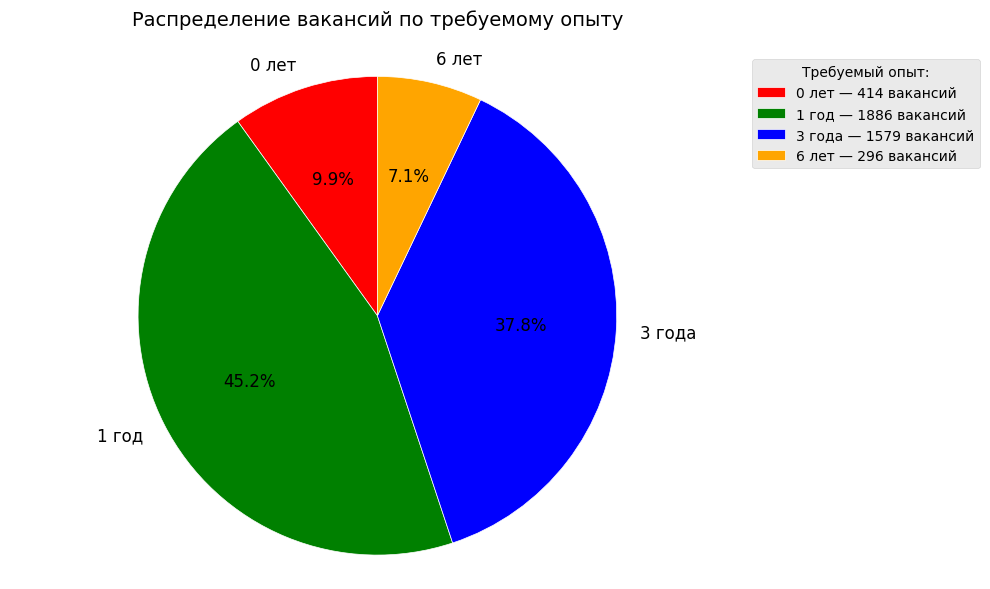

In [ ]:
# Данные
experience_counts = df['required_experience'].value_counts().sort_index()  # Сортировка

# Цвета
colors = ['red', 'green', 'blue', 'orange']

# Визуализация
plt.figure(figsize=(10, 6))
plt.pie(
    experience_counts,
    labels=[f"{exp} {'год' if exp == 1 else 'года' if exp == 3 else 'лет'}" for exp in experience_counts.index],  # Правильное склонение
    autopct='%1.1f%%',
    startangle=90,
    colors=colors,
    wedgeprops={'edgecolor': 'white', 'linewidth': 0.5},
    textprops={'fontsize': 12}
)

# Легенда
plt.legend(
    title="Требуемый опыт:",
    loc="upper left",
    bbox_to_anchor=(1, 1),
    labels=[f"{exp} {'год' if exp == 1 else 'года' if 2 <= exp <=4 else 'лет'} — {count} вакансий"
            for exp, count in experience_counts.items()]
)

plt.title('Распределение вакансий по требуемому опыту', pad=20, fontsize=14)
plt.axis('equal')
plt.tight_layout()
plt.show()

Как видно из диаграммы, доля предложений без опыта составляет 9.9% (414 вакансий). Это указывает на низкую доступность стажировок для студентов начальных курсов. Большинство вакансий (45.2%) предполагает наличие минимального опыта 1-3 года.

- 1 год опыта: 1,886 вакансий (45.2%)  
- 3 года опыта: 1,579 вакансий (37.8%)  
- Суммарно: 83% всех вакансий  

**Вывод:** Гипотеза №1 подтверждается — рынок действительно ориентирован на специалистов middle-уровень. Доля таких вакансий более чем в 4 раза выше, чем для новичков и экспертов .  

Пик спроса на 1 год опыта (45.2%) может также указывать на высокую текучесть кадров или активный рост компаний, требующих специалистов без длительного адаптационного периода.


## 2. Тип занятости и график работы
Составим столбчатые диаграммы, чтобы визуализировать распределение частот по перемерым employment_type и work_schedule:

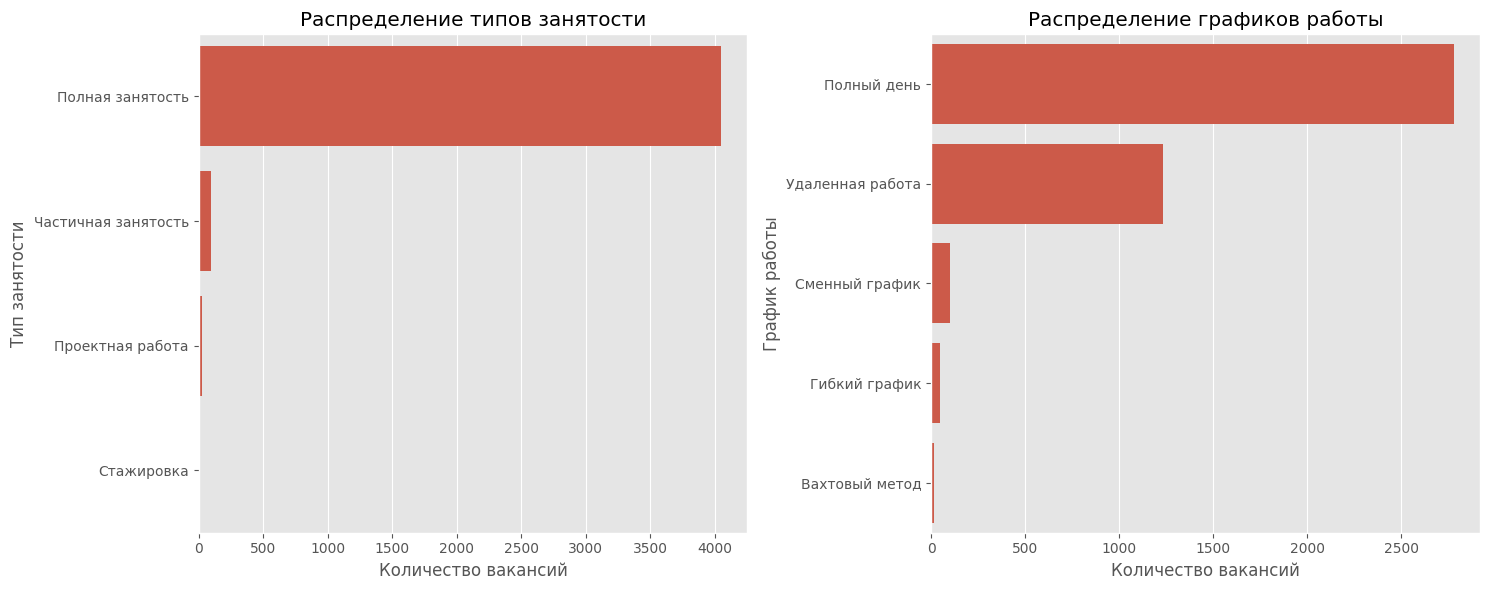

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# employment_type
sns.countplot(data=df, y='employment_type', ax=ax1, order=df['employment_type'].value_counts().index)
ax1.set_title('Распределение типов занятости')
ax1.set_xlabel('Количество вакансий')
ax1.set_ylabel('Тип занятости')

# work_schedule
sns.countplot(data=df, y='work_schedule', ax=ax2, order=df['work_schedule'].value_counts().index)
ax2.set_title('Распределение графиков работы')
ax2.set_xlabel('Количество вакансий')
ax2.set_ylabel('График работы')

plt.tight_layout()
plt.show()

Графики показывают, что полная занятость на полный рабочий день — стандартное требование в данной сфере, что несомненно затрудняет трудоустройство студентов.

1. Типы занятости:  
   - Полная занятость доминирует (>4000 вакансий; ~90% от общего числа)  
   - Частичная занятость хоть и на втором месте по популярности, но все равно занимает минимальную долю (менее 5%)  

2. Графики работы:  
   - Полный день доминирует (~2800 вакансий)  
   - Гибкий график и удалённая работа — заметно меньшая доля (суммарно ~25-35%)  

**Вывод:** Гипотеза №2 опровергается.  
- В сфере бизнес-информатики преобладает полная занятость и стандартный полный день.  
- Гибкие форматы есть, но не доминируют.  

Рынок все еще ориентирован на классические форматы даже в IT секторе.

## 3. Распределение зарплат

Теперь создадим интерактивную гистограмму по минимальным и максимальным значения зарплаты

In [11]:
# Подготовка данных
min_salaries = df['min_salary'].dropna()
max_salaries = df['max_salary'].dropna()


# Вычисление статистик
min_mean = min_salaries.mean()
min_median = min_salaries.median()
max_mean = max_salaries.mean()
max_median = max_salaries.median()


# Создание графика
fig = go.Figure()

fig.add_trace(go.Histogram(
    x=min_salaries,
    nbinsx=30,
    name='Минимальная зарплата',
    opacity=0.5,
    marker_color='red'
))

fig.add_trace(go.Histogram(
    x=max_salaries,
    nbinsx=30,
    name='Максимальная зарплата',
    opacity=0.5,
    marker_color='blue'
))

# Добавление линий
line_params = [
    (min_mean, 'red', 'dash', 'Ср. мин'),
    (min_median, 'red', 'dot', 'Мед. мин'),
    (max_mean, 'blue', 'dash', 'Ср. макс'),
    (max_median, 'blue', 'dot', 'Мед. макс')
]

for value, color, line_style, prefix in line_params:
    fig.add_shape(
        type='line',
        x0=value,
        y0=0,
        x1=value,
        y1=1,
        yref='paper',
        line=dict(
            color=color,
            dash=line_style,
            width=2
        ),
        name=f'{prefix}: {value:.0f}'
    )

    fig.add_trace(go.Scatter(
        x=[None],
        y=[None],
        mode='lines',
        line=dict(
            color=color,
            dash=line_style,
            width=2
        ),
        name=f'{prefix}: {value:.0f}',
        showlegend=True
    ))


# Настройка макета
fig.update_layout(
    title='Распределение зарплат с показателями среднего и медианы',
    xaxis_title='Зарплата',
    yaxis_title='Количество вакансий',
    bargap=0.1,
    hovermode='x unified',
    barmode='overlay',
    height=600,
    width=900,

    # Настройки легенды
    legend=dict(
        orientation='v',
        yanchor='top',
        y=0.98,
        xanchor='right',
        x=0.98,
        bgcolor='rgba(255,255,255,0.9)',
        bordercolor='rgba(0,0,0,0.2)',
        borderwidth=1,
        font=dict(size=10)
    ),

    # Отступы
    margin=dict(l=50, r=50, b=50, t=80, pad=4)
)


# Добавление кнопок управления
fig.update_layout(
    updatemenus=[
        dict(
            type="buttons",
            direction="right",
            buttons=list([
                dict(label="Все",
                     method="restyle",
                     args=[{"visible": [True, True, True, True, True, True]}]),
                dict(label="Только мин.",
                     method="restyle",
                     args=[{"visible": [True, False, True, True, False, False]}]),
                dict(label="Только макс.",
                     method="restyle",
                     args=[{"visible": [False, True, False, False, True, True]}])
            ]),
            pad={"r": 10, "t": 10},
            showactive=True,
            x=0.15,
            xanchor="left",
            y=1.15,
            yanchor="top"
        )
    ]
)


print('Общее количество непустых значений:', df['min_salary'].count() + df['max_salary'].count())
fig.show()

Общее количество непустых значений: 2773


На графике видно, что большинство вакансий предлагает зарплаты в пределах 50-200 тысяч рублей. Минимальные зарплаты в основном держатся около 100 тысяч (медиана), а среднее значение чуть выше (117 тысяч), что связано с наличием крупных выбросов. У максимальных зарплат типичное значение 140 тысяч, но среднее достигает почти 170 тысяч, а некоторые предложения доходят до 800 тысяч.

1. Разница между медианными и средними значениями.
   - Мин.: +16.7%
   - Макс.: +20.6%

2. Охват медианной вилки:
   - Общее количество непустых значений составляет 2773.
   - По графику видно, что в медианную вилку 100-140к входит около 630 вакансий, что занимает всего 22.7%.

Вывод:  
Гипотеза №3 частично подтверждается:
- Разница между медианой и средним значением действительно не превышает 30% (16.7% и 20.6%).
- Охват медианной вилки (100-140k руб.) составляет всего 22.7%.

# 4. Зависимость средних зарплат от требуемого опыта

Лучшим решением, чтобы показать диапазон значений зарплаты, будет boxplot:

In [ ]:
# Рассчитываем среднюю зарплату
df['avg_salary'] = (df['min_salary'] + df['max_salary']) / 2

# Строим boxplot с явным указанием категорий
fig = px.box(df,
             x='required_experience',
             y='avg_salary',
             title='Зависимость зарплаты от требуемого опыта',
             labels={'required_experience': 'Минимальный требуемый опыт (лет)', 'avg_salary': 'Средняя зарплата'},
             category_orders={"required_experience": [0, 1, 3, 6]})

# Настраиваем ось X
fig.update_layout(
    xaxis={
        'type': 'category',
        'tickvals': [0, 1, 3, 6],
        'ticktext': ['0 лет', '1 год', '3 года', '6 лет']
    },
    width=800
)

fig.show()

График показывает общую зависимость значений зарплат от выличины опыта.

1. Динамика медианы зарплат:
   - 0 лет → 1 год:  
     Рост 75к → 105к (+40%)
   - 1 год → 3 года:  
     Рост 105к → 165к (+57.1% или +25.4% за год)
   - 3 года → 6 лет:  
     Рост 165к → 250к (+51.5% или 14.9% за год)
   - Средний рост:
     22.2% за год

2. Разрыв min/max:
   - 0 лет:
     2.25к → 190к (разница 187.76)
   - 1 год:  
     27.5к → 230к (разница 202.5; +7.85%)
   - 3 года:  
     1.65к → 350к (разница 348.4; +72.05%)
   - 6 лет:  
     82.8к → 456.5к (разница 373.7; +7.26%)
   - Средний рост:
     9.2% за год

**Вывод:**  
Гипотеза №4 частично подтверждается:
- Средний рост зарплаты превышает 15% в год и составляет 22.2%.    
- Разрыв min/max действительно увеличивается с опытом, но нелинейно и в среднем не превышает 10% за год опыта.

Ключевые отклонения:
1. Скачок в медианах на первом году опыта (+40%) высок, что говорит о наличии опыта как об определяющем факторе для размера зарплаты.
2. Рост замедляется после 3 лет опыта.


Итог:  
Тренд на рост есть, процент зависит от карьерного этапа.

# 5. Соотношение величины зарплаты и популярности должности

Составим столбчатые диаграммы с самыми часто встречающимися вакансиями и с самыми оплачиваемыми должностями.

In [25]:
top_companies_vacancies = df['position'].value_counts().head(20)
fig = px.bar(top_companies_vacancies,
             x=top_companies_vacancies.values,
             y=top_companies_vacancies.index,
             orientation='h',
             title='Топ-20 компаний по количеству вакансий',
             width = 800)

fig.update_layout(
    xaxis_title='Количество вакансий',
    yaxis_title='Должность')

fig.show()

In [35]:
# Группируем по должности и считаем среднюю зарплату
top_positions = df.groupby('position')['avg_salary'].mean().sort_values(ascending=False).head(20)

# Интерактивный барплот
fig = px.bar(top_positions,
             x=top_positions.values,
             y=top_positions.index,
             orientation='h',
             title='Топ-20 самых оплачиваемых должностей',
             labels={'x': 'Средняя зарплата', 'y': 'Должность'},
             color=top_positions.values,
             color_continuous_scale='Viridis',
             width = 1200)

fig.update_traces(hovertemplate='<b>%{y}</b><br>Средняя зарплата: %{x:,.0f} ₽<extra></extra>')
fig.update_layout(coloraxis_colorbar_title='Средняя зарплата')

fig.show()

1. Топ-10 частых должностей:  
   - Преобладают:  
     - Бизнес-аналитик  
     - Системный аналитик  
     - Менеджер по продажам  
   - Максимальная частота: 52 вакансий на позицию.  

2. Топ-20 оплачиваемых должностей:  
   - Узкие специализации:  
     - Fullstack-разработчик senior  
     - Tech Lead Backend Developer  
     - Senior QA Engineer  
   - Руководящие роли:  
     - ИТ Директор  
     - CTO  
     - CPO  
   - Зарплаты: 350–700к руб.  

**Вывод:**  
Гипотеза №5 подтверждается.  
- Высокооплачиваемые должности (Top-20) требуют узкой экспертизы (1C-архитекторы, Senior-разработчики) или топ-менеджмента (CTO, CPO).  
- Частые вакансии (Top-10) — массовые роли (аналитики, менеджеры), где зарплаты ниже.  

  
1. Разрыв в зарплатах:  
   - Средние зарплаты в Top-20 в 2-3 раза выше, чем у массовых позиций.  
2. Редкость высокооплачиваемых ролей:  
   - В Top-20 нет пересечений с Top-10 по частоте.  


Итог:  
Рынок можно разделить на "массовый" (частые, но менее оплачиваемые вакансии) и "специализированный" (редкие, но высокодоходные роли).

# Компании

В заключение, визуализируем топ работодателей по количеству объявлений в данной сфере:

In [28]:
top_companies_vacancies = df['company'].value_counts().head(20)
fig = px.bar(top_companies_vacancies,
             x=top_companies_vacancies.values,
             y=top_companies_vacancies.index,
             orientation='h',
             title='Топ-20 компаний по количеству вакансий',
             width = 800)

fig.update_layout(
    xaxis_title='Количество вакансий',
    yaxis_title='Компания')

fig.show()

# Итоги исследования

---

## Основные выводы:

### Распределение вакансий
- Большинство предложений требуют 1-3 года опыта
- Только 10% вакансий доступны новичкам

### Условия работы
- 90% вакансий предполагают полную занятость
- Гибкие форматы работы встречаются редко (25-35%)
- Удаленная работа не является распространенной практикой

### Динамика зарплат
- Стартовый уровень: 75-105 тыс. рублей
- После 3 лет опыта: 165 тыс. рублей (+57%)
- После 6 лет: 250 тыс. рублей
- Максимальные зарплаты (до 700 тыс.) у узких специалистов и руководителей

---

## Итоги проверки гипотез

1. Спрос на middle-уровень - подтверждена  
   Большинство вакансий действительно для специалистов с 1-3 годами опыта

2. Преобладание гибкого графика - не подтверждена  
   "Классическая" занятость остается основной формой

3. Зарплатная вилка - частично подтверждена  
   Разница между медианой и средним не превышает 30%, но охват узкий (23%)

4. Рост зарплат с опытом - частично подтверждена  
   Наблюдается стабильный рост медианной зарплаты, особенно в первые 3 года, но разница min/max зарплатных предложений растет медленно

5. Разделение на массовые и нишевые роли - подтверждена  
   Высокооплачиваемые позиции требуют узкой специализации

---

## Достижение цели исследования
Исследование позволило выявить ключевые закономерности рынка труда в сфере бизнес-информатики:
- Требования к минимальному опыту работы
- Преобладание традиционных форм занятости
- Большой разброс зарплат, зависящий от конкретных навыков, опыта и работодателя
- Неравномерная динамика роста зарплат, прослеживаемая от увеличения опыта
- Двухсекторная структура рынка (массовые и специализированные позиции)

---

## Ключевые рекомендации для студентов "Бизнес-информатики":

1. Получение первого опыта работы уже в процессе обучения даст гораздо большую конкурентоспособность к моменту выпуска

2. Развитие специализации позволит расчитывать на гораздо более высокую зарплату

3. Попасть в одну из крупных компаний проще, чем кажется, т.к. именно они выставляют наибольшее число объявлений и гарантируют хорошие условия труда